# パターンテンプレート：ロジスティック回帰を使った分類におけるデータ前処理

## ライブラリロード

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. データを読み込む

In [2]:
# https://www.kaggle.com/c/titanic から入手できる。
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 1. データ構造を確認する

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 幾つかの特性に欠損が存在することがわかる。

### 特性の定義を確認する。（わかりにくいもののみ）

In [5]:
%%html
<style>table {float: left}</style>

|変数名|値|
|---|---|
|Survived|目的変数（0 = 死亡; 1 = 生存）|
|Pclass|客室のグレード(1 = 1st; 2 = 2nd; 3 = 3rd)|
|Sibsp|乗船していた兄弟または配偶者の数|
|Parch|乗船していた親または子どもの数|
|Cabin|客室番号|
|Embarked|乗船した港|

### 数値以外の特性(質的データ)の記録状況を確認する。

In [6]:
train_df['Name'].describe()

count                  891
unique                 891
top       Tobin, Mr. Roger
freq                     1
Name: Name, dtype: object

In [7]:
train_df['Sex'].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

In [8]:
train_df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [9]:
train_df['Cabin'].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [10]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [11]:
test_df['Name'].describe()

count                             418
unique                            418
top       Nilsson, Miss. Berta Olivia
freq                                1
Name: Name, dtype: object

In [12]:
test_df['Sex'].describe()

count      418
unique       2
top       male
freq       266
Name: Sex, dtype: object

In [13]:
test_df['Ticket'].describe()

count          418
unique         363
top       PC 17608
freq             5
Name: Ticket, dtype: object

In [14]:
test_df['Cabin'].describe()

count                  91
unique                 76
top       B57 B59 B63 B66
freq                    3
Name: Cabin, dtype: object

In [15]:
test_df['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

### 上記の特性のうち、'Name','Ticket','Cabin'の3つは一意なデータの数が多いため学習の対象から除外する。

In [16]:
test_df = test_df.drop(['Name','Ticket','Cabin'], axis=1)
train_df = train_df.drop(['Name','Ticket','Cabin'], axis=1)

### データの内容を確認する(最初の5行のみ)。

In [17]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [18]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


### 基本統計量を確認する。

In [19]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 2. 目的変数・説明変数間の分布を確認する

### 数値データの分布をヒストグラムで可視化する。

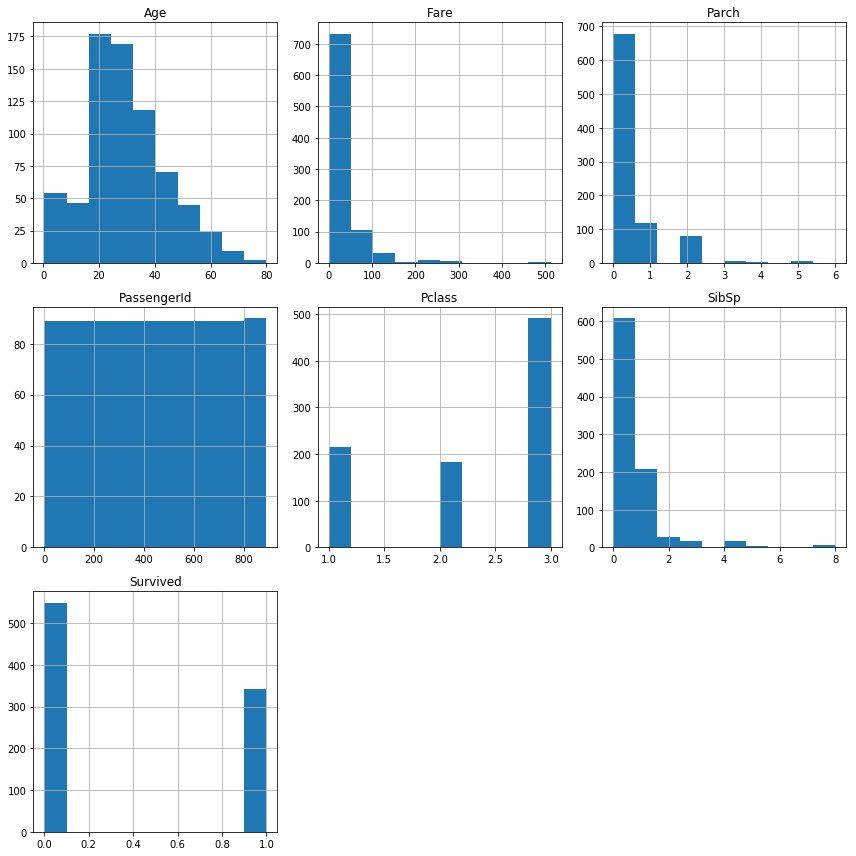

In [21]:
train_df.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

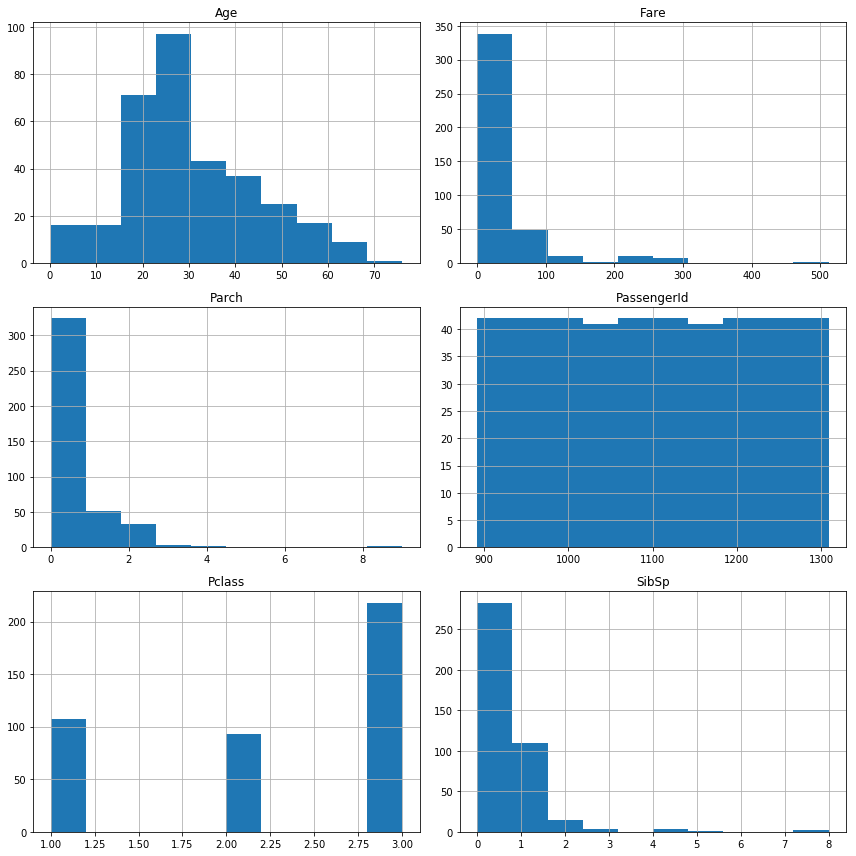

In [22]:
test_df.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

### 訓練データ、テストデータの分布は似ているので、以降はテストデータの可視化は省略する。

### pairplotを使って、数値の特性の対と'Survived'の関係を可視化してみる。

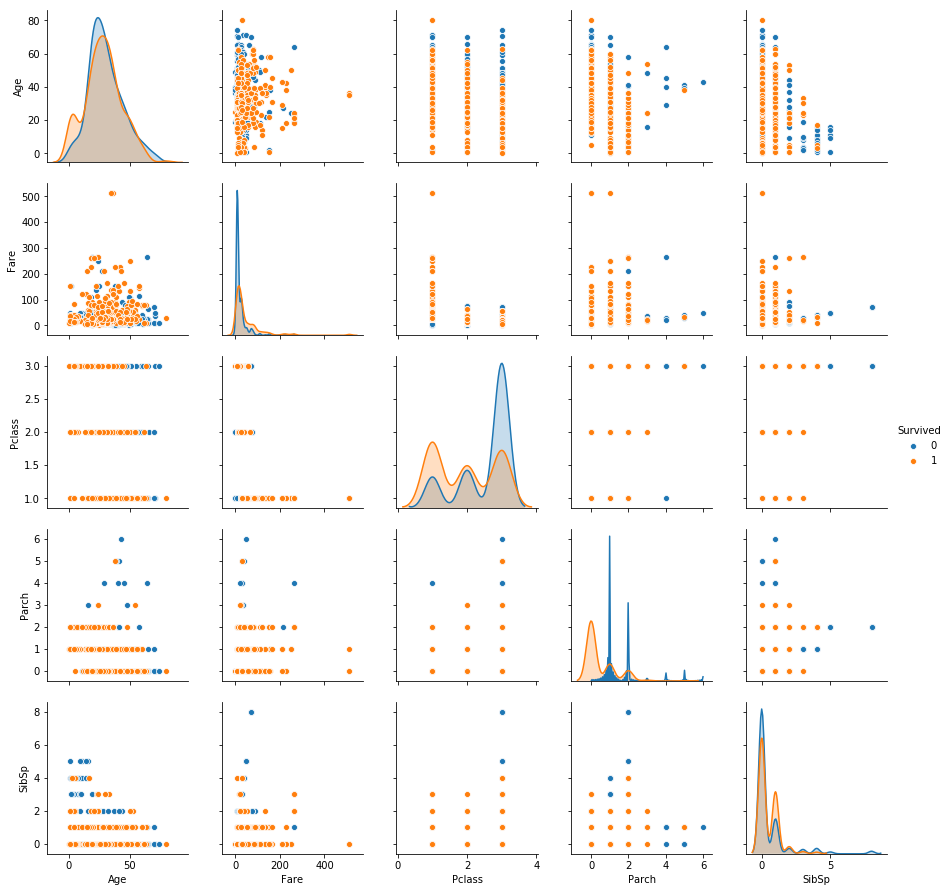

In [23]:
sns.pairplot(data=train_df, hue='Survived', vars=['Age','Fare','Pclass','Parch','SibSp'], diag_kind='auto', kind='scatter')

### factorplotを使って、数値以外の特性('Sex', 'Embarked')と数値の特性('Age', 'Pclass')の対、および、'Survived'の関係を可視化してみる。

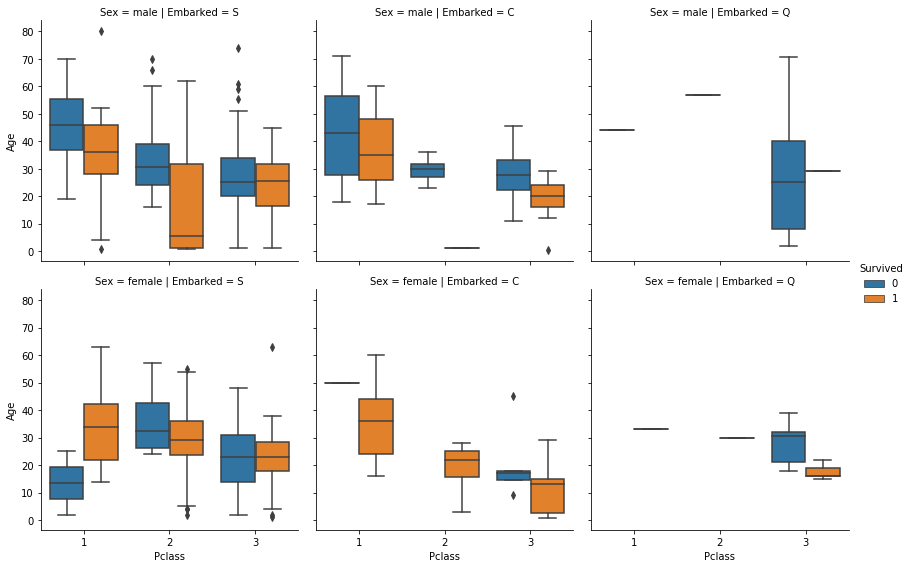

In [24]:
sns.factorplot(x='Pclass',y='Age',hue='Survived',row='Sex',col='Embarked',kind='box', data=train_df, height=4)

### catplotを使って、数値以外の特性('Embarked')と数値の特性('Pclass')の対、数値以外の特性('Sex')、および、'Survived'の関係を可視化してみる。

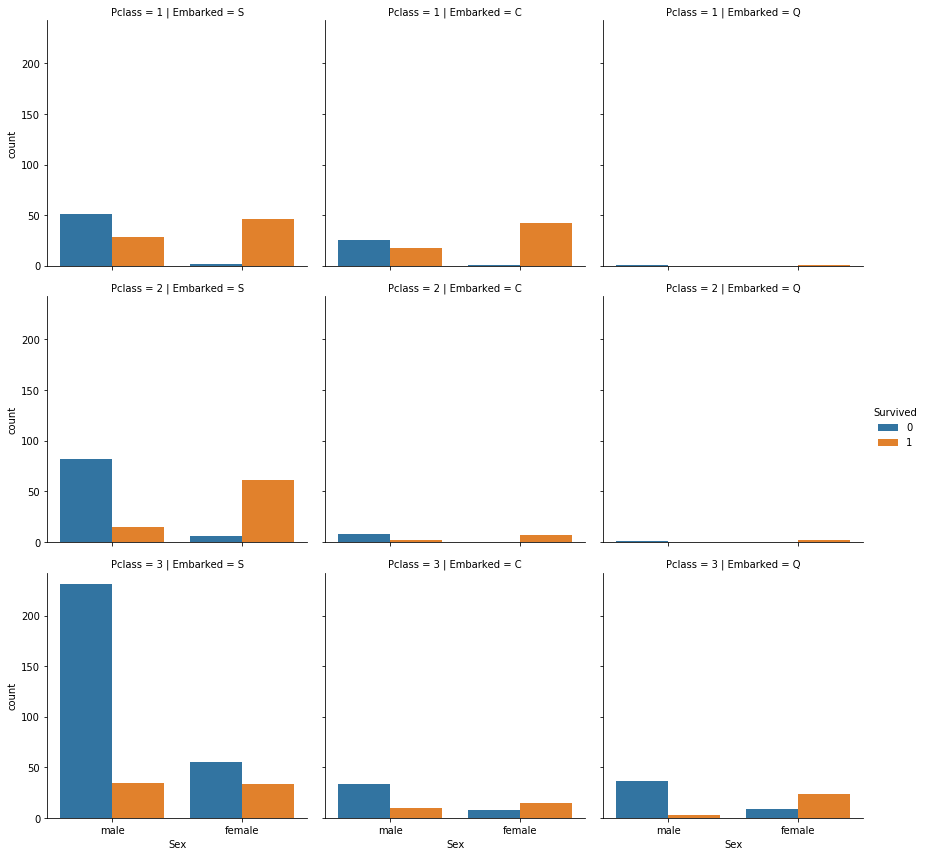

In [25]:
sns.catplot(x='Sex',hue='Survived', row='Pclass', col='Embarked', kind='count', height=4,data=train_df)

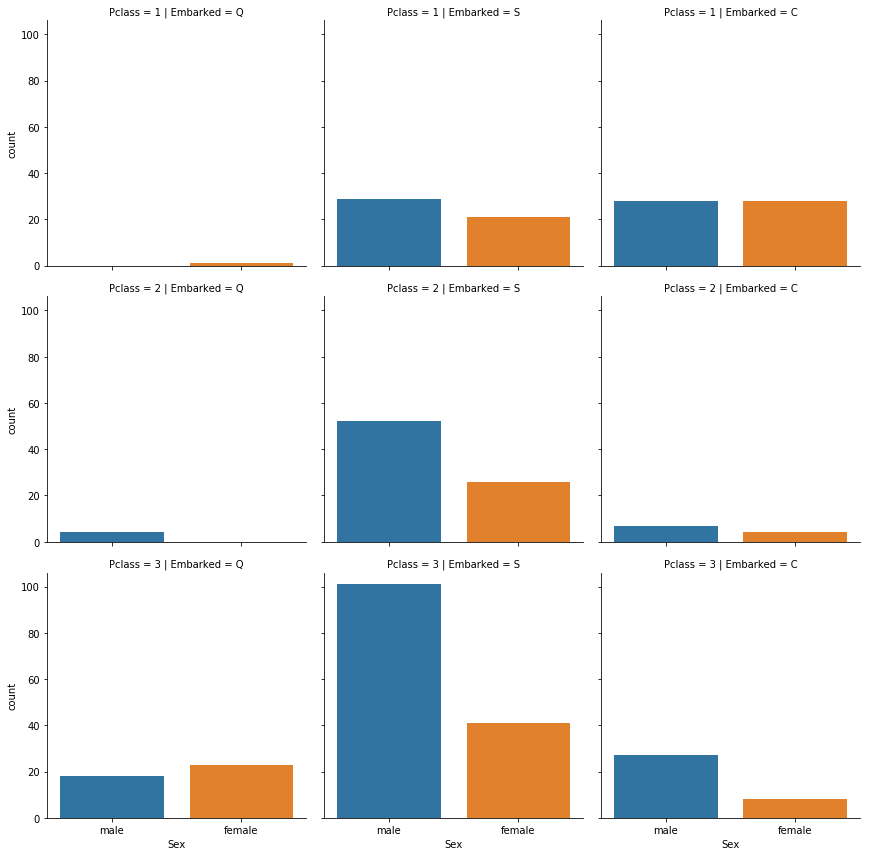

In [26]:
sns.catplot(x='Sex', row='Pclass', col='Embarked', kind='count', height=4, data=test_df)

## 3. 説明変数間の多重共線性を確認する

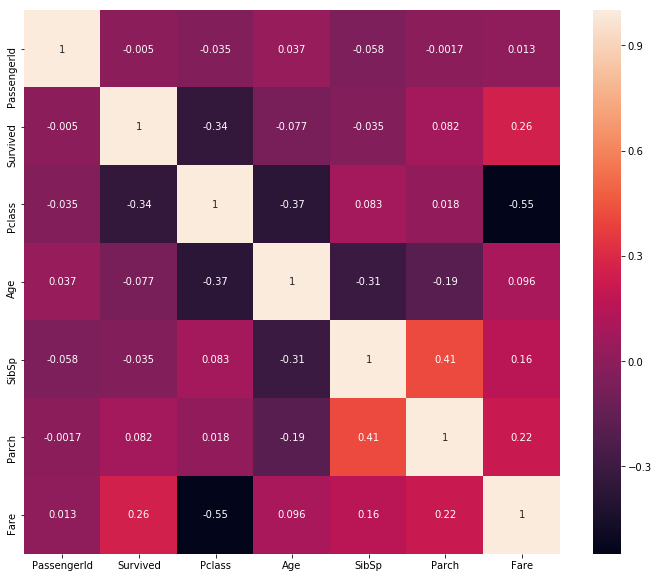

In [27]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(train_df.corr(),annot=True)

### 特に、多重共線性が疑われる相関関係が高い特性の組は存在しないと考える。

## 4. データの欠損に対処する

### 特性'Age'の欠損に対して、訓練データの平均値を、男女別に求めて補完する。

In [28]:
age_train_mean = train_df.groupby('Sex').Age.mean()
age_train_mean['male']


30.72664459161148

In [29]:
age_train_mean['female']

27.915708812260537

In [30]:
age_train_mean = train_df.groupby('Sex').Age.mean()
train_df.loc[train_df['Age'].isnull() & (train_df['Sex']=='male'),'Age'] = age_train_mean['male']
train_df.loc[train_df['Age'].isnull() & (train_df['Sex']=='female'),'Age'] = age_train_mean['female']

test_df.loc[test_df['Age'].isnull() & (test_df['Sex']=='male'),'Age'] = age_train_mean['male']
test_df.loc[test_df['Age'].isnull() & (test_df['Sex']=='female'),'Age'] = age_train_mean['female']

### 特性(Fare)の欠損に対して、平均値を求めて、補完する。

In [31]:
test_df.Fare.mean()

35.6271884892086

In [32]:
test_df.loc[test_df['Fare'].isnull(),'Fare'] = test_df.Fare.mean()

### 以降、データに操作を加えた際には、都度、DataFrame.info()メソッドでデータの状態を確認する、あるいは、データ全体を出力して内容を確認する。

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


## 5. データの尺度を正規化する

### 数値の特性(Age, Fare)について、StandardScalerによる標準化を行う。

In [35]:
SS = StandardScaler()

train_na = SS.fit_transform(train_df[['Age','Fare']].values)
test_na = SS.fit_transform(test_df[['Age','Fare']].values)

std_train_df = pd.DataFrame(train_na, columns=['Age_std','Fare_std'])
std_test_df = pd.DataFrame(test_na, columns=['Age_std','Fare_std'])

In [36]:
std_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
Age_std     891 non-null float64
Fare_std    891 non-null float64
dtypes: float64(2)
memory usage: 14.0 KB


In [37]:
std_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
Age_std     418 non-null float64
Fare_std    418 non-null float64
dtypes: float64(2)
memory usage: 6.6 KB


In [38]:
train_df = train_df.join(std_train_df)

In [39]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_std,Fare_std
0,1,0,3,male,22.000000,1,0,7.2500,S,-0.594732,-0.502445
1,2,1,1,female,38.000000,1,0,71.2833,C,0.635319,0.786845
2,3,1,3,female,26.000000,0,0,7.9250,S,-0.287220,-0.488854
3,4,1,1,female,35.000000,1,0,53.1000,S,0.404684,0.420730
4,5,0,3,male,35.000000,0,0,8.0500,S,0.404684,-0.486337
5,6,0,3,male,30.726645,0,0,8.4583,Q,0.076156,-0.478116
6,7,0,1,male,54.000000,0,0,51.8625,S,1.865370,0.395814
7,8,0,3,male,2.000000,3,1,21.0750,S,-2.132296,-0.224083
8,9,1,3,female,27.000000,0,2,11.1333,S,-0.210341,-0.424256
9,10,1,2,female,14.000000,1,0,30.0708,C,-1.209758,-0.042956


In [40]:
test_df=test_df.join(std_test_df)

In [41]:
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_std,Fare_std
0,892,3,male,34.500000,0,0,7.8292,Q,0.340531,-0.498407
1,893,3,female,47.000000,1,0,7.0000,S,1.329961,-0.513274
2,894,2,male,62.000000,0,0,9.6875,Q,2.517277,-0.465088
3,895,3,male,27.000000,0,0,8.6625,S,-0.253127,-0.483466
4,896,3,female,22.000000,1,1,12.2875,S,-0.648899,-0.418471
5,897,3,male,14.000000,0,0,9.2250,S,-1.282134,-0.473381
6,898,3,female,30.000000,0,0,7.6292,Q,-0.015664,-0.501993
7,899,2,male,26.000000,1,1,29.0000,S,-0.332281,-0.118823
8,900,3,female,18.000000,0,0,7.2292,C,-0.965517,-0.509165
9,901,3,male,21.000000,2,0,24.1500,S,-0.728053,-0.205781


### 標準化の前の特性('Age','Fare')を削除する。

In [42]:
train_df.drop(['Age','Fare'], axis=1, inplace=True)

In [43]:
test_df.drop(['Age','Fare'], axis=1, inplace=True)

## 7. 質的データを変換する

### 二値の質的データ

### 特性'Sex'について、'male','female'を'0','1'に変換する。

In [44]:
if train_df['Sex'].dtype == 'O':
    train_df['Sex'] = train_df['Sex'].replace(['male','female'],[0,1])

if test_df['Sex'].dtype == 'O':    
    test_df['Sex'] = test_df['Sex'].replace(['male','female'],[0,1])

### 三値以上の質的データ

### OneHotEncodingのために、訓練データとテストデータをまとめる。

In [45]:
all_df=pd.concat([train_df,test_df], axis=0)
embarked_all_df=all_df['Embarked']

### LabelEncoderにかけて、整数値化された質的データに変換する。

In [46]:
lenc = LabelEncoder()

embarked_all_na=lenc.fit_transform(embarked_all_df.values.astype(str))

### OneHotEncoderにかけて、OneHot数値配列への変換を行う。

In [47]:
ohenc = OneHotEncoder(sparse=False)

embarked_all_na_ohenc = ohenc.fit_transform(embarked_all_na.reshape(-1, 1))

### OneHotEncoderにより生成された２次元配列のサイズを確認する。

In [48]:
embarked_all_na_ohenc.shape

(1309, 4)

### 上記配列を、元のデータに結合する。

In [49]:
column_names=[]
for cls in lenc.classes_:
  new_column_name = "Embarked_" + cls
  column_names.append(new_column_name)
temp = pd.DataFrame(index=all_df.index, columns =column_names, data=embarked_all_na_ohenc)
all_df_new = pd.concat([all_df, temp], axis=1)

In [50]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age_std         1309 non-null float64
Embarked        1307 non-null object
Fare_std        1309 non-null float64
Parch           1309 non-null int64
PassengerId     1309 non-null int64
Pclass          1309 non-null int64
Sex             1309 non-null int64
SibSp           1309 non-null int64
Survived        891 non-null float64
Embarked_C      1309 non-null float64
Embarked_Q      1309 non-null float64
Embarked_S      1309 non-null float64
Embarked_nan    1309 non-null float64
dtypes: float64(7), int64(5), object(1)
memory usage: 143.2+ KB


### OneHotEncodingのためにまとめていたデータを、再び訓練データとテストデータに分割する。

In [51]:
train_df = all_df_new[:train_df.shape[0]]
train_df

,Age_std,Embarked,Fare_std,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,-0.594732,S,-0.502445,0,1,3,0,1,0.0,0.0,0.0,1.0,0.0
1,0.635319,C,0.786845,0,2,1,1,1,1.0,1.0,0.0,0.0,0.0
2,-0.287220,S,-0.488854,0,3,3,1,0,1.0,0.0,0.0,1.0,0.0
3,0.404684,S,0.420730,0,4,1,1,1,1.0,0.0,0.0,1.0,0.0
4,0.404684,S,-0.486337,0,5,3,0,0,0.0,0.0,0.0,1.0,0.0
5,0.076156,Q,-0.478116,0,6,3,0,0,0.0,0.0,1.0,0.0,0.0
6,1.865370,S,0.395814,0,7,1,0,0,0.0,0.0,0.0,1.0,0.0
7,-2.132296,S,-0.224083,1,8,3,0,3,0.0,0.0,0.0,1.0,0.0
8,-0.210341,S,-0.424256,2,9,3,1,0,1.0,0.0,0.0,1.0,0.0
9,-1.209758,C,-0.042956,0,10,2,1,1,1.0,1.0,0.0,0.0,0.0


In [52]:
test_df = all_df_new[train_df.shape[0]:]
test_df

,Age_std,Embarked,Fare_std,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.340531,Q,-0.498407,0,892,3,0,0,NaN,0.0,1.0,0.0,0.0
1,1.329961,S,-0.513274,0,893,3,1,1,NaN,0.0,0.0,1.0,0.0
2,2.517277,Q,-0.465088,0,894,2,0,0,NaN,0.0,1.0,0.0,0.0
3,-0.253127,S,-0.483466,0,895,3,0,0,NaN,0.0,0.0,1.0,0.0
4,-0.648899,S,-0.418471,1,896,3,1,1,NaN,0.0,0.0,1.0,0.0
5,-1.282134,S,-0.473381,0,897,3,0,0,NaN,0.0,0.0,1.0,0.0
6,-0.015664,Q,-0.501993,0,898,3,1,0,NaN,0.0,1.0,0.0,0.0
7,-0.332281,S,-0.118823,1,899,2,0,1,NaN,0.0,0.0,1.0,0.0
8,-0.965517,C,-0.509165,0,900,3,1,0,NaN,1.0,0.0,0.0,0.0
9,-0.728053,S,-0.205781,0,901,3,0,2,NaN,0.0,0.0,1.0,0.0


### OneHotEncoderにかける前の特性('Embarked')、OneHotEncoderにかけた後の相関性の高い特性('Embarked_S')、学習対象外の不要な特性('Embarked_nan')を削除する。

In [53]:
train_df.drop(['Embarked','Embarked_S','Embarked_nan'], axis=1, inplace=True)

In [54]:
test_df.drop(['Embarked','Embarked_S','Embarked_nan'], axis=1, inplace=True)

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
Age_std        891 non-null float64
Fare_std       891 non-null float64
Parch          891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
SibSp          891 non-null int64
Survived       891 non-null float64
Embarked_C     891 non-null float64
Embarked_Q     891 non-null float64
dtypes: float64(5), int64(5)
memory usage: 76.6 KB


In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
Age_std        418 non-null float64
Fare_std       418 non-null float64
Parch          418 non-null int64
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
SibSp          418 non-null int64
Survived       0 non-null float64
Embarked_C     418 non-null float64
Embarked_Q     418 non-null float64
dtypes: float64(5), int64(5)
memory usage: 35.9 KB


### 特性('Embarked')の欠損2件を、この段階で削除する。

In [57]:
train_df.dropna(inplace=True)

### テストデータには、特性'Survived'は記録されていないので、削除する。

In [58]:
test_df.drop(['Survived'], axis=1, inplace=True)

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
Age_std        891 non-null float64
Fare_std       891 non-null float64
Parch          891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
SibSp          891 non-null int64
Survived       891 non-null float64
Embarked_C     891 non-null float64
Embarked_Q     891 non-null float64
dtypes: float64(5), int64(5)
memory usage: 76.6 KB


In [60]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
Age_std        418 non-null float64
Fare_std       418 non-null float64
Parch          418 non-null int64
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
SibSp          418 non-null int64
Embarked_C     418 non-null float64
Embarked_Q     418 non-null float64
dtypes: float64(4), int64(5)
memory usage: 32.7 KB


## (付録)モデル生成・評価・予測

### モデル生成

In [61]:
X = train_df.drop(['PassengerId','Survived'],axis=1)
y = train_df['Survived']


In [62]:
X

,Age_std,Fare_std,Parch,Pclass,Sex,SibSp,Embarked_C,Embarked_Q
0,-0.594732,-0.502445,0,3,0,1,0.0,0.0
1,0.635319,0.786845,0,1,1,1,1.0,0.0
2,-0.287220,-0.488854,0,3,1,0,0.0,0.0
3,0.404684,0.420730,0,1,1,1,0.0,0.0
4,0.404684,-0.486337,0,3,0,0,0.0,0.0
5,0.076156,-0.478116,0,3,0,0,0.0,1.0
6,1.865370,0.395814,0,1,0,0,0.0,0.0
7,-2.132296,-0.224083,1,3,0,3,0.0,0.0
8,-0.210341,-0.424256,2,3,1,0,0.0,0.0
9,-1.209758,-0.042956,0,2,1,1,1.0,0.0


In [63]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
5      0.0
6      0.0
7      0.0
8      1.0
9      1.0
10     1.0
11     1.0
12     0.0
13     0.0
14     0.0
15     1.0
16     0.0
17     1.0
18     0.0
19     1.0
20     0.0
21     1.0
22     1.0
23     1.0
24     0.0
25     1.0
26     0.0
27     0.0
28     1.0
29     0.0
      ... 
861    0.0
862    1.0
863    0.0
864    0.0
865    1.0
866    1.0
867    0.0
868    0.0
869    1.0
870    0.0
871    1.0
872    0.0
873    0.0
874    1.0
875    1.0
876    0.0
877    0.0
878    0.0
879    1.0
880    1.0
881    0.0
882    0.0
883    0.0
884    0.0
885    0.0
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

### 交差検証とグリッドサーチを同時に実行する。

In [64]:
parameters = {
#        'C'      : [0.01, 0.1, 1, 10,  50.0, 60.0, 70.0, 80.0, 100.0, 150.0],
        'C'      : np.logspace(-5,5,100),
        'random_state'      : [0]
}

grid_search = GridSearchCV(
                    LogisticRegression(), 
                    parameters, 
                    cv = 5
                )

grid_search.fit(X.values, y.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-05, 1.26186e-05, ..., 7.92483e+04, 1.00000e+05]), 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### モデル評価

In [65]:
# スコアとモデルパラメータのベスト値
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8002244668911336
{'C': 0.13848863713938717, 'random_state': 0}


In [66]:
# 説明変数の重みづけ値（回帰係数）
print(DataFrame([X.columns, grid_search.best_estimator_.coef_[0]]).T)
print("Intercept = ",grid_search.best_estimator_.intercept_)

            0          1
0     Age_std  -0.405905
1    Fare_std   0.192408
2       Parch -0.0435654
3      Pclass  -0.786515
4         Sex      2.148
5       SibSp  -0.266889
6  Embarked_C   0.342634
7  Embarked_Q   0.213948
Intercept =  [0.51353224]


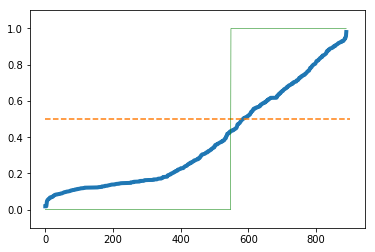

In [67]:
# モデルの当てはまり具合の見える化
def sigmoid(x):
    return 1 / (1+np.exp(-x))

X_value=grid_search.best_estimator_.decision_function(X.values)

#グラフ作成
plt.plot(np.sort(sigmoid(X_value)), lw='4')
plt.plot([0,900],[0.5, 0.5], linestyle='dashed')
plt.plot(np.sort(y), color='green', lw='0.5')
plt.ylim(-0.1,1.1)
plt.show()

In [68]:
# 上図から、やや死亡（Y軸が0～0.5）側の予測に偏っている。

### 予測

In [69]:
X1 = test_df.drop(['PassengerId'],axis=1)
test_predict = grid_search.predict(X1.values)

### Kaggleにアップデートするデータ作成

In [70]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived':np.array(test_predict)})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
